In [2]:
import os, pickle, glob
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql.types import Row, StructField, StructType, StringType, IntegerType, BinaryType
import pyspark.sql.functions as F
import matplotlib.pyplot as plt
import pyspark.pandas as ps
import plotly
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.linalg import Vectors
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import StandardScaler
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml import pipeline
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

Matplotlib created a temporary cache directory at /scratch/cscholz/job_30686679/matplotlib-t0jl2oin because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
/usr/local/spark/python/pyspark/pandas/__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


In [3]:
sc = SparkSession.builder \
    .config("spark.driver.memory", "64g") \
    .config("spark.executor.memory", "32g") \
    .config("spark.executor.instances", 7) \
    .getOrCreate()

## Import Data

In [4]:
path = 'merged_data.csv'

In [5]:
df = sc.read.csv(path, header=True, inferSchema=True, escape="\"")

## Initial Exploration

In [5]:
df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- rank: integer (nullable = true)
 |-- date: date (nullable = true)
 |-- artist: string (nullable = true)
 |-- url: string (nullable = true)
 |-- region: string (nullable = true)
 |-- chart: string (nullable = true)
 |-- trend: string (nullable = true)
 |-- streams: double (nullable = true)
 |-- track_id: string (nullable = true)
 |-- album: string (nullable = true)
 |-- popularity: double (nullable = true)
 |-- duration_ms: double (nullable = true)
 |-- explicit: boolean (nullable = true)
 |-- release_date: string (nullable = true)
 |-- available_markets: string (nullable = true)
 |-- af_danceability: double (nullable = true)
 |-- af_energy: double (nullable = true)
 |-- af_key: double (nullable = true)
 |-- af_loudness: double (nullable = true)
 |-- af_mode: double (nullable = true)
 |-- af_speechiness: double (nullable = true)
 |-- af_acousticness: double (nullable = true)
 |-- af_instrumentalness: doub

In [6]:
df.columns

['_c0',
 'title',
 'rank',
 'date',
 'artist',
 'url',
 'region',
 'chart',
 'trend',
 'streams',
 'track_id',
 'album',
 'popularity',
 'duration_ms',
 'explicit',
 'release_date',
 'available_markets',
 'af_danceability',
 'af_energy',
 'af_key',
 'af_loudness',
 'af_mode',
 'af_speechiness',
 'af_acousticness',
 'af_instrumentalness',
 'af_liveness',
 'af_valence',
 'af_tempo',
 'af_time_signature']

In [7]:
#count number of records and columns in the dataset
print('number of records: ' + str(df.count()))
print('number of columns: ' + str(len(df.columns)))

number of records: 26174269
number of columns: 29


In [6]:
#drop null records from dataset
df2 = df.dropna("any")
df2.show()

+---+--------------------+----+----------+--------------------+--------------------+---------+------+-------------+--------+--------------------+--------------------+----------+-----------+--------+------------+--------------------+---------------+---------+------+-----------+-------+--------------+---------------+-------------------+-----------+----------+--------+-----------------+
|_c0|               title|rank|      date|              artist|                 url|   region| chart|        trend| streams|            track_id|               album|popularity|duration_ms|explicit|release_date|   available_markets|af_danceability|af_energy|af_key|af_loudness|af_mode|af_speechiness|af_acousticness|af_instrumentalness|af_liveness|af_valence|af_tempo|af_time_signature|
+---+--------------------+----+----------+--------------------+--------------------+---------+------+-------------+--------+--------------------+--------------------+----------+-----------+--------+------------+---------------

In [9]:
#count number of records after nulls are dropped
print('number of records: ' + str(df2.count()))

number of records: 20302985


In [10]:
#check for duplicates
duplicates = df2.groupBy(df2.columns)\
    .agg(F.count("*").alias("count"))\
    .filter(F.col("count") > 1)

duplicates.show()

+---+-----+----+----+------+---+------+-----+-----+-------+--------+-----+----------+-----------+--------+------------+-----------------+---------------+---------+------+-----------+-------+--------------+---------------+-------------------+-----------+----------+--------+-----------------+-----+
|_c0|title|rank|date|artist|url|region|chart|trend|streams|track_id|album|popularity|duration_ms|explicit|release_date|available_markets|af_danceability|af_energy|af_key|af_loudness|af_mode|af_speechiness|af_acousticness|af_instrumentalness|af_liveness|af_valence|af_tempo|af_time_signature|count|
+---+-----+----+----+------+---+------+-----+-----+-------+--------+-----+----------+-----------+--------+------------+-----------------+---------------+---------+------+-----------+-------+--------------+---------------+-------------------+-----------+----------+--------+-----------------+-----+
+---+-----+----+----+------+---+------+-----+-----+-------+--------+-----+----------+-----------+--------+

In [11]:
#check data types of revised df
df2.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- rank: integer (nullable = true)
 |-- date: date (nullable = true)
 |-- artist: string (nullable = true)
 |-- url: string (nullable = true)
 |-- region: string (nullable = true)
 |-- chart: string (nullable = true)
 |-- trend: string (nullable = true)
 |-- streams: double (nullable = true)
 |-- track_id: string (nullable = true)
 |-- album: string (nullable = true)
 |-- popularity: double (nullable = true)
 |-- duration_ms: double (nullable = true)
 |-- explicit: boolean (nullable = true)
 |-- release_date: string (nullable = true)
 |-- available_markets: string (nullable = true)
 |-- af_danceability: double (nullable = true)
 |-- af_energy: double (nullable = true)
 |-- af_key: double (nullable = true)
 |-- af_loudness: double (nullable = true)
 |-- af_mode: double (nullable = true)
 |-- af_speechiness: double (nullable = true)
 |-- af_acousticness: double (nullable = true)
 |-- af_instrumentalness: doub

In [7]:
#convert strings to integers where needed
df2 = df2.withColumn("streams", df2["streams"].cast("Integer"))
df2 = df2.withColumn("popularity", df2["popularity"].cast("Integer"))
df2 = df2.withColumn("duration_ms", df2["duration_ms"].cast("Integer"))

In [13]:
#recheck data types of revised df
df2.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- rank: integer (nullable = true)
 |-- date: date (nullable = true)
 |-- artist: string (nullable = true)
 |-- url: string (nullable = true)
 |-- region: string (nullable = true)
 |-- chart: string (nullable = true)
 |-- trend: string (nullable = true)
 |-- streams: integer (nullable = true)
 |-- track_id: string (nullable = true)
 |-- album: string (nullable = true)
 |-- popularity: integer (nullable = true)
 |-- duration_ms: integer (nullable = true)
 |-- explicit: boolean (nullable = true)
 |-- release_date: string (nullable = true)
 |-- available_markets: string (nullable = true)
 |-- af_danceability: double (nullable = true)
 |-- af_energy: double (nullable = true)
 |-- af_key: double (nullable = true)
 |-- af_loudness: double (nullable = true)
 |-- af_mode: double (nullable = true)
 |-- af_speechiness: double (nullable = true)
 |-- af_acousticness: double (nullable = true)
 |-- af_instrumentalness: d

**Descriptive Statistics for Select Fields**

In [14]:
#streams, popularity, duration
df2.select("streams", "popularity", "duration_ms").describe().show()

+-------+------------------+------------------+------------------+
|summary|           streams|        popularity|       duration_ms|
+-------+------------------+------------------+------------------+
|  count|          20302985|          20302985|          20302985|
|   mean| 55271.43975799617| 49.01087578993926|210171.90830540436|
| stddev|209668.97662269627|30.451214851538786| 45995.50468765216|
|    min|              1001|                 0|                 0|
|    max|          19749704|                96|           9318296|
+-------+------------------+------------------+------------------+



In [15]:
#numerical af values set 1
df2.select("af_danceability", "af_energy", "af_key", "af_loudness", "af_mode", "af_speechiness").describe().show()

+-------+-------------------+-------------------+-----------------+------------------+------------------+-------------------+
|summary|    af_danceability|          af_energy|           af_key|       af_loudness|           af_mode|     af_speechiness|
+-------+-------------------+-------------------+-----------------+------------------+------------------+-------------------+
|  count|           20302985|           20302985|         20302985|          20302985|          20302985|           20302985|
|   mean| 0.6866474105310121| 0.6451090361438403|5.335599716002351|-6.128795240699589|0.5746761867774616|0.10820268905286996|
| stddev|0.13376797620633846|0.16292426985450953| 3.63979592547731|2.3848890367402027|0.4943920298378325| 0.0975365826314738|
|    min|                0.0|                0.0|              0.0|             -60.0|               0.0|                0.0|
|    max|              0.988|                1.0|             11.0|             2.216|               1.0|             

In [16]:
#number af values set 2
df2.select("af_acousticness", "af_instrumentalness", "af_liveness", "af_valence", "af_tempo", "af_time_signature").describe().show()

+-------+-------------------+--------------------+-------------------+------------------+------------------+-------------------+
|summary|    af_acousticness| af_instrumentalness|        af_liveness|        af_valence|          af_tempo|  af_time_signature|
+-------+-------------------+--------------------+-------------------+------------------+------------------+-------------------+
|  count|           20302985|            20302985|           20302985|          20302985|          20302985|           20302985|
|   mean| 0.2561906183443458| 0.00813501493904418|0.16781152442854555| 0.525369189282275| 121.0747297951098| 3.9704190295170885|
| stddev|0.24305700270926303|0.059829645564625604|0.12737166427864896|0.2215482247463698|29.510442445218686|0.25955334651543194|
|    min|                0.0|                 0.0|                0.0|               0.0|               0.0|                0.0|
|    max|              0.996|               0.993|              0.993|             0.999|        

In [17]:
#show record count for top 20 regions in descending order
df2.groupBy("region").count().sort(F.col("count").desc()).show()

+--------------+------+
|        region| count|
+--------------+------+
|        Brazil|364503|
|     Argentina|364367|
| United States|364081|
|       Austria|363878|
|     Australia|362152|
|        Global|362125|
|        Canada|361287|
|United Kingdom|359715|
|   Switzerland|358661|
|     Indonesia|358376|
|     Hong Kong|358373|
|    Costa Rica|358367|
|   New Zealand|358366|
|      Colombia|358366|
|     Singapore|358364|
|       Ecuador|358352|
|       Denmark|358348|
|   Philippines|358347|
|       Belgium|358345|
|       Ireland|358344|
+--------------+------+
only showing top 20 rows



In [18]:
#show for top 10 regions only
df2.groupBy("region").count().sort(F.col("count").desc()).show(10)

+--------------+------+
|        region| count|
+--------------+------+
|        Brazil|364503|
|     Argentina|364367|
| United States|364081|
|       Austria|363878|
|     Australia|362152|
|        Global|362125|
|        Canada|361287|
|United Kingdom|359715|
|   Switzerland|358661|
|     Indonesia|358376|
+--------------+------+
only showing top 10 rows



In [19]:
#group by artists that occur most frequently
df2.groupBy("artist").count().sort(F.col("count").desc()).show()

+---------------+------+
|         artist| count|
+---------------+------+
|     Ed Sheeran|366022|
|  Billie Eilish|230007|
|    Post Malone|196620|
|      Bad Bunny|187425|
|  Ariana Grande|174396|
|       Dua Lipa|173678|
|          Drake|156844|
|Imagine Dragons|144067|
|   XXXTENTACION|142029|
|     The Weeknd|133966|
|            BTS|132299|
|  Justin Bieber|120873|
|   Travis Scott|111777|
|     Juice WRLD|111656|
|   Shawn Mendes|102381|
|   Harry Styles| 97672|
|         Maluma| 95663|
|       Maroon 5| 95206|
|  Lewis Capaldi| 93542|
|      Sam Smith| 88078|
+---------------+------+
only showing top 20 rows



In [20]:
#group by top 10 artists that occur most frequently
df2.groupBy("artist").count().sort(F.col("count").desc()).show(10)

+---------------+------+
|         artist| count|
+---------------+------+
|     Ed Sheeran|366022|
|  Billie Eilish|230007|
|    Post Malone|196620|
|      Bad Bunny|187425|
|  Ariana Grande|174396|
|       Dua Lipa|173678|
|          Drake|156844|
|Imagine Dragons|144067|
|   XXXTENTACION|142029|
|     The Weeknd|133966|
+---------------+------+
only showing top 10 rows



In [21]:
#return unique trend types and record counts of each
df2.groupBy("trend").count().sort(F.col("count").desc()).show()

+-------------+-------+
|        trend|  count|
+-------------+-------+
|    MOVE_DOWN|8967284|
|      MOVE_UP|7826957|
|SAME_POSITION|2329367|
|    NEW_ENTRY|1179377|
+-------------+-------+



In [22]:
#return records for af time signature
df2.groupBy("af_time_signature").count().sort(F.col("count").desc()).show()

+-----------------+--------+
|af_time_signature|   count|
+-----------------+--------+
|              4.0|19399285|
|              3.0|  631707|
|              5.0|  211781|
|              1.0|   60192|
|              0.0|      20|
+-----------------+--------+



In [23]:
#return record counts for explicit content
df2.groupBy("explicit").count().sort(F.col("count").desc()).show()

+--------+--------+
|explicit|   count|
+--------+--------+
|   false|14447299|
|    true| 5855686|
+--------+--------+



In [24]:
#return records for af mode
df2.groupBy("af_mode").count().sort(F.col("count").desc()).show()

+-------+--------+
|af_mode|   count|
+-------+--------+
|    1.0|11667642|
|    0.0| 8635343|
+-------+--------+



In [25]:
#return unique count of all records where the number of streams is above average
avgNumStrm = df2.select(F.mean("streams")).collect()[0][0]
df2.filter(df2.streams > avgNumStrm).count()

3403712

In [26]:
#return unique count of all records where the popularity is greater than the average
avgPop = df2.select(F.mean("popularity")).collect()[0][0]
df2.filter(df2.popularity > avgPop).count()

12526503

In [27]:
#return unique count of all records where the duration in ms is greater than the average
avgDur = df2.select(F.mean("duration_ms")).collect()[0][0]
df2.filter(df2.duration_ms > avgDur).count()

9043527

In [28]:
#count all records where region is in NAFTA (USA, Mexico, Canada)
df2.filter(F.col("Region").isin("United States", "Mexico", "Canada")).count()

1083657

In [29]:
#songs that populated the most in this dataset
df2.groupBy("artist", "title").count().sort(F.col("count").desc()).show(10)

+--------------------+--------------------+-----+
|              artist|               title|count|
+--------------------+--------------------+-----+
|          Ed Sheeran|        Shape of You|65262|
|     Imagine Dragons|            Believer|58191|
|          Ed Sheeran|             Perfect|52392|
|       Lewis Capaldi|   Someone You Loved|50975|
|          The Weeknd|     Blinding Lights|47747|
|         Tones And I|        Dance Monkey|43263|
|Lady Gaga, Bradle...|             Shallow|41109|
|            Dua Lipa|     Don't Start Now|40240|
|Post Malone, Swae...|Sunflower - Spide...|39645|
|       Billie Eilish|             bad guy|39470|
+--------------------+--------------------+-----+
only showing top 10 rows



In [30]:
#return top 10 drake songs that are referenced in the dataframe
df3 = df2.filter(F.col("artist")=="Drake")
df3.groupBy("artist", "title").count().sort(F.col("count").desc()).show(10)

+------+--------------------+-----+
|artist|               title|count|
+------+--------------------+-----+
| Drake|          God's Plan|21782|
| Drake|        Toosie Slide|13664|
| Drake|      In My Feelings|12241|
| Drake|        Passionfruit| 9423|
| Drake|Laugh Now Cry Lat...| 9234|
| Drake|       Nice For What| 9047|
| Drake|Money In The Grav...| 8918|
| Drake|             Nonstop| 8226|
| Drake|           Fake Love| 6635|
| Drake|Wants and Needs (...| 3768|
+------+--------------------+-----+
only showing top 10 rows



In [31]:
#return the regions where drake appears most frequently on a top list
df3.groupBy("artist", "region").count().sort(F.col("count").desc()).show(10)

+------+--------------+-----+
|artist|        region|count|
+------+--------------+-----+
| Drake|        Canada| 9216|
| Drake| United States| 8226|
| Drake|United Kingdom| 6973|
| Drake|     Australia| 6002|
| Drake|        Global| 5960|
| Drake|       Ireland| 5591|
| Drake|  South Africa| 5226|
| Drake|   New Zealand| 4935|
| Drake|      Portugal| 4685|
| Drake|        Greece| 4225|
+------+--------------+-----+
only showing top 10 rows



In [32]:
#count unique drake songs that appear in these top lists
df3.agg({"title": "approx_count_distinct"}).show()

+----------------------------+
|approx_count_distinct(title)|
+----------------------------+
|                         120|
+----------------------------+



In [33]:
#return the top 10 post malone songs that occur the most in these lists
df4 = df2.filter(F.col("artist")=="Post Malone")
df4.groupBy("artist", "title").count().sort(F.col("count").desc()).show(10)

+-----------+--------------------+-----+
|     artist|               title|count|
+-----------+--------------------+-----+
|Post Malone|             Circles|30885|
|Post Malone|rockstar (feat. 2...|30308|
|Post Malone|          Better Now|24294|
|Post Malone|                Wow.|16857|
|Post Malone|Psycho (feat. Ty ...|15450|
|Post Malone|        I Fall Apart|14026|
|Post Malone|Goodbyes (Feat. Y...|12113|
|Post Malone|         Candy Paint| 6576|
|Post Malone|             Go Flex| 4819|
|Post Malone|Take What You Wan...| 4317|
+-----------+--------------------+-----+
only showing top 10 rows



In [34]:
#return the regions where post malone occurs most frequently on a top list 
df4.groupBy("artist", "region").count().sort(F.col("count").desc()).show(10)

+-----------+--------------+-----+
|     artist|        region|count|
+-----------+--------------+-----+
|Post Malone| United States|10436|
|Post Malone|        Canada| 8887|
|Post Malone|     Australia| 7907|
|Post Malone|   New Zealand| 7612|
|Post Malone|        Global| 7377|
|Post Malone|United Kingdom| 6458|
|Post Malone|       Ireland| 6408|
|Post Malone|      Portugal| 5426|
|Post Malone|        Norway| 5358|
|Post Malone|       Denmark| 5235|
+-----------+--------------+-----+
only showing top 10 rows



In [35]:
#count unique post malone songs that appear in these top lists
df4.agg({"title": "approx_count_distinct"}).show()

+----------------------------+
|approx_count_distinct(title)|
+----------------------------+
|                          46|
+----------------------------+



In [36]:
#top 10 referenced artists for united states
df5 = df2.filter(F.col("region")=="United States")
df5.groupBy("artist", "region").count().sort(F.col("count").desc()).show(10)

+-------------+-------------+-----+
|       artist|       region|count|
+-------------+-------------+-----+
|   Juice WRLD|United States|10524|
|  Post Malone|United States|10436|
| XXXTENTACION|United States| 8807|
|        Drake|United States| 8226|
|Billie Eilish|United States| 7317|
| Lil Uzi Vert|United States| 6498|
| Travis Scott|United States| 5890|
|Ariana Grande|United States| 4721|
|       Khalid|United States| 4715|
|      J. Cole|United States| 4599|
+-------------+-------------+-----+
only showing top 10 rows



In [37]:
#top 10 referenced artists in canada
df6 = df2.filter(F.col("region")=="Canada")
df6.groupBy("artist", "region").count().sort(F.col("count").desc()).show(10)

+-------------+------+-----+
|       artist|region|count|
+-------------+------+-----+
|        Drake|Canada| 9216|
|  Post Malone|Canada| 8887|
|   Ed Sheeran|Canada| 7799|
|   Juice WRLD|Canada| 6800|
|Billie Eilish|Canada| 6267|
| Travis Scott|Canada| 5482|
| XXXTENTACION|Canada| 5430|
|Ariana Grande|Canada| 4346|
|       Khalid|Canada| 4109|
|   The Weeknd|Canada| 3979|
+-------------+------+-----+
only showing top 10 rows



In [38]:
#top 10 referenced artists for mexico
df7 = df2.filter(F.col("region")=="Mexico")
df7.groupBy("artist", "region").count().sort(F.col("count").desc()).show(10)

+--------------------+------+-----+
|              artist|region|count|
+--------------------+------+-----+
|           Bad Bunny|Mexico| 9210|
|         Luis Miguel|Mexico| 7753|
|     Christian Nodal|Mexico| 7619|
|Banda MS de Sergi...|Mexico| 7203|
|              Maluma|Mexico| 6490|
|          Ed Sheeran|Mexico| 4222|
|               Ozuna|Mexico| 4029|
|            J Balvin|Mexico| 3716|
|     Cartel De Santa|Mexico| 3455|
| Alejandro Fernández|Mexico| 3328|
+--------------------+------+-----+
only showing top 10 rows



In [39]:
#top 10 most referenced songs in america
df5.groupBy("artist", "title", "region").count().sort(F.col("count").desc()).show(10)

+------------+--------------------+-------------+-----+
|      artist|               title|       region|count|
+------------+--------------------+-------------+-----+
|Travis Scott|          goosebumps|United States| 1778|
|XXXTENTACION|      Jocelyn Flores|United States| 1563|
|Lil Uzi Vert|       XO Tour Llif3|United States| 1549|
|     J. Cole|      No Role Modelz|United States| 1474|
|  Juice WRLD|All Girls Are The...|United States| 1342|
|  Juice WRLD|        Lucid Dreams|United States| 1332|
|XXXTENTACION|Fuck Love (feat. ...|United States| 1285|
| Post Malone|        I Fall Apart|United States| 1271|
|XXXTENTACION|                SAD!|United States| 1207|
|        Joji|SLOW DANCING IN T...|United States| 1180|
+------------+--------------------+-------------+-----+
only showing top 10 rows



In [40]:
#top 10 referenced songs in canada
df6.groupBy("artist", "title", "region").count().sort(F.col("count").desc()).show(10)

+--------------------+--------------------+------+-----+
|              artist|               title|region|count|
+--------------------+--------------------+------+-----+
|        James Arthur|Say You Won't Let Go|Canada| 1701|
|        Travis Scott|          goosebumps|Canada| 1655|
|          Ed Sheeran|             Perfect|Canada| 1589|
|             Journey|Don't Stop Believin'|Canada| 1419|
|          Juice WRLD|        Lucid Dreams|Canada| 1312|
|          Ed Sheeran|        Shape of You|Canada| 1245|
|        XXXTENTACION|      Jocelyn Flores|Canada| 1189|
|     Imagine Dragons|            Believer|Canada| 1187|
|Post Malone, Swae...|Sunflower - Spide...|Canada| 1153|
|Lady Gaga, Bradle...|             Shallow|Canada| 1151|
+--------------------+--------------------+------+-----+
only showing top 10 rows



In [41]:
#top 10 referenced songs in mexico
df7.groupBy("artist", "title", "region").count().sort(F.col("count").desc()).show(10)

+--------------------+--------------------+------+-----+
|              artist|               title|region|count|
+--------------------+--------------------+------+-----+
|         Luis Miguel|Ahora Te Puedes M...|Mexico| 1792|
| Alejandro Fernández|Me Dediqué a Perd...|Mexico| 1790|
|       León Larregui|             Brillas|Mexico| 1789|
|         Danny Ocean|           Me Rehúso|Mexico| 1764|
|     Christian Nodal|          Adiós Amor|Mexico| 1708|
|     Imagine Dragons|            Believer|Mexico| 1571|
|           Hombres G|Devuélveme a mi c...|Mexico| 1551|
|Banda MS de Sergi...|El Color de Tus Ojos|Mexico| 1509|
|     Christian Nodal|       Probablemente|Mexico| 1381|
|       León Larregui|               Locos|Mexico| 1380|
+--------------------+--------------------+------+-----+
only showing top 10 rows



In [42]:
#albums referenced the most frequenly
df2.groupBy("artist", "album").count().sort(F.col("count").desc()).show(10)

+---------------+--------------------+------+
|         artist|               album| count|
+---------------+--------------------+------+
|     Ed Sheeran|          ÷ (Deluxe)|193170|
|Imagine Dragons|              Evolve|100959|
|  Billie Eilish|WHEN WE ALL FALL ...| 96792|
|       Dua Lipa|    Future Nostalgia| 90933|
|    Post Malone|beerbongs & bentleys| 82782|
|   Harry Styles|           Fine Line| 80658|
|     The Weeknd|         After Hours| 79926|
|   XXXTENTACION|                   ?| 77766|
| Olivia Rodrigo|                SOUR| 69165|
|     Ed Sheeran|No.6 Collaboratio...| 65075|
+---------------+--------------------+------+
only showing top 10 rows



In [43]:
#albums referenced the most frequenly in the united states
df5.groupBy("artist", "album").count().sort(F.col("count").desc()).show(10)

+--------------+--------------------+-----+
|        artist|               album|count|
+--------------+--------------------+-----+
|    Juice WRLD|Goodbye & Good Ri...| 4549|
|   Post Malone|beerbongs & bentleys| 4194|
|  XXXTENTACION|                  17| 3954|
|  XXXTENTACION|                   ?| 3674|
|Kendrick Lamar|               DAMN.| 2990|
| Billie Eilish|WHEN WE ALL FALL ...| 2872|
|  Lil Uzi Vert|       Luv Is Rage 2| 2743|
|   Post Malone|Hollywood's Bleeding| 2572|
|         Drake|            Scorpion| 2542|
|   Post Malone|     Stoney (Deluxe)| 2505|
+--------------+--------------------+-----+
only showing top 10 rows



In [44]:
#albums referenced the most frequenly in canada
df6.groupBy("artist", "album").count().sort(F.col("count").desc()).show(10)

+---------------+--------------------+-----+
|         artist|               album|count|
+---------------+--------------------+-----+
|     Ed Sheeran|          ÷ (Deluxe)| 4465|
|    Post Malone|beerbongs & bentleys| 3637|
|          Drake|            Scorpion| 2955|
|     Juice WRLD|Goodbye & Good Ri...| 2836|
|  Billie Eilish|WHEN WE ALL FALL ...| 2509|
| Kendrick Lamar|               DAMN.| 2427|
|   XXXTENTACION|                   ?| 2392|
|Imagine Dragons|              Evolve| 2319|
|    Post Malone|Hollywood's Bleeding| 2280|
|      Pop Smoke|Shoot For The Sta...| 2255|
+---------------+--------------------+-----+
only showing top 10 rows



In [45]:
#albums referenced the most frequenly in mexico
df7.groupBy("artist", "album").count().sort(F.col("count").desc()).show(10)

+--------------------+--------------------+-----+
|              artist|               album|count|
+--------------------+--------------------+-----+
|           Bad Bunny|            YHLQMDLG| 3373|
|     Christian Nodal|      Me Dejé Llevar| 3062|
|         Luis Miguel|     Busca Una Mujer| 2768|
|Banda MS de Sergi...|La Mejor Versión ...| 2522|
|          Ed Sheeran|          ÷ (Deluxe)| 2358|
|     Imagine Dragons|              Evolve| 2301|
|            J Balvin|             Colores| 2109|
|         Luis Miguel| Soy Como Quiero Ser| 2040|
|               Ozuna|              Odisea| 1947|
|     Christian Nodal|               Ahora| 1930|
+--------------------+--------------------+-----+
only showing top 10 rows



In [46]:
#return all records where popularity is 0
df2.filter(F.col("popularity")==0).count()

4039255

## Initial Visualizations

In [47]:
#convert to a pyspark.pandas dataframe for visualization work
df2_viz = ps.DataFrame(df2)

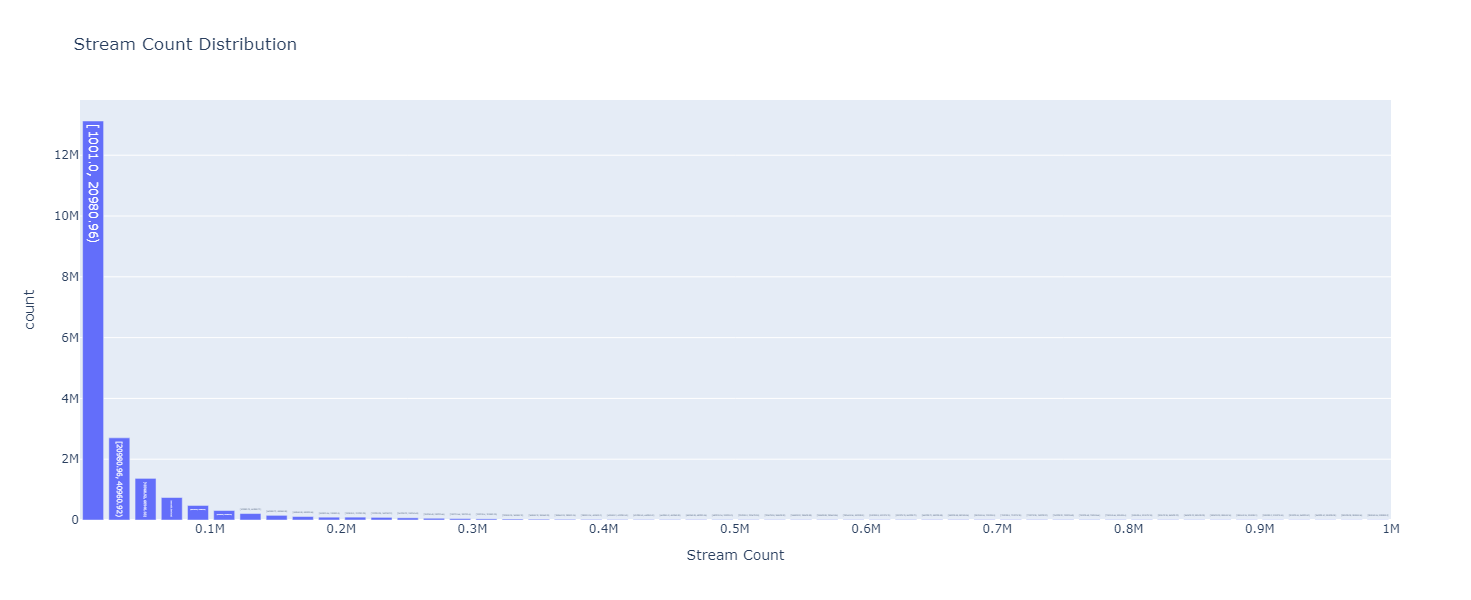

In [48]:
#histogram of stream count distribution
#filter outliers for stream counts - for use in stream histogram only
df2_viz_stm = ps.DataFrame(df2.filter(df2.streams < 1000000))

fig = df2_viz_stm["streams"].plot.hist(bins = 50, alpha = 0.5)

fig.update_layout(width = 1000, height = 600, title = "Stream Count Distribution", xaxis_title = "Stream Count")

fig.show()

The stream count distribution is skewed to the right, and is a unimodal distribution with one distinct peak

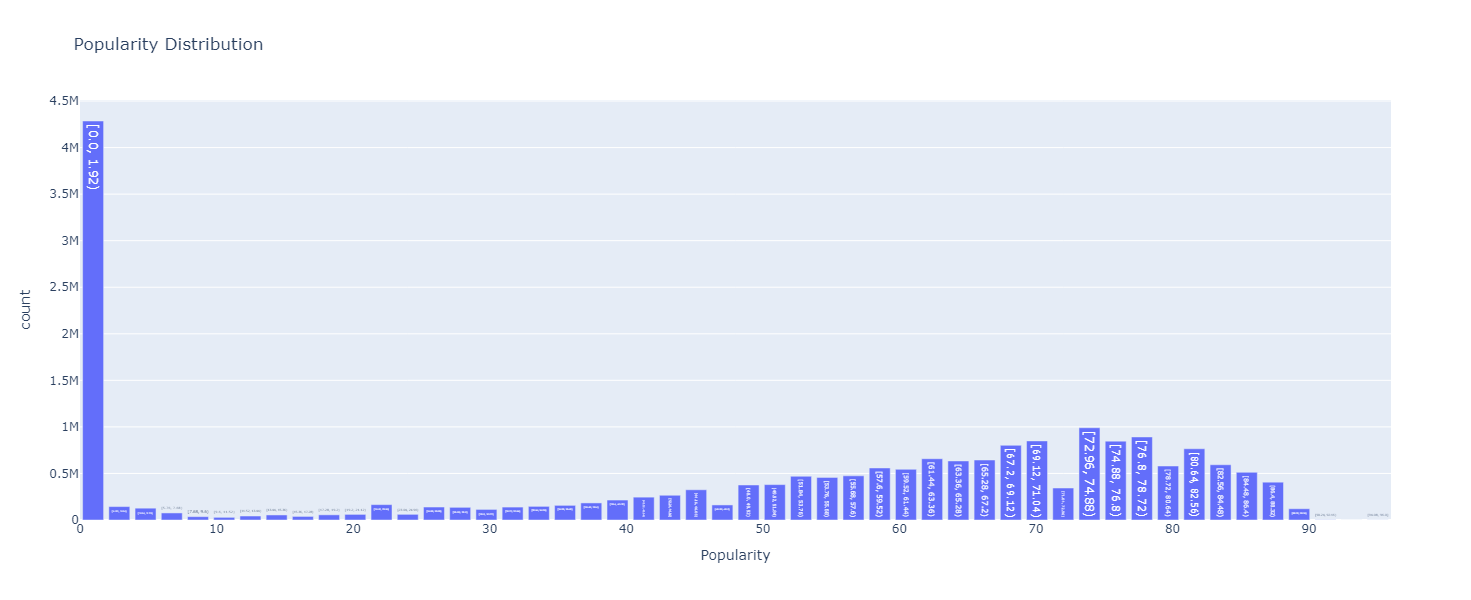

In [49]:
#histogram of popularity distribution
fig = df2_viz["popularity"].plot.hist(bins = 50, alpha = 0.5)

fig.update_layout(width = 1000, height = 600, title = "Popularity Distribution", xaxis_title = "Popularity")

fig.show()

The distribution of popularity is skewed to the right, and is a unimodal distribution with one distinct peak

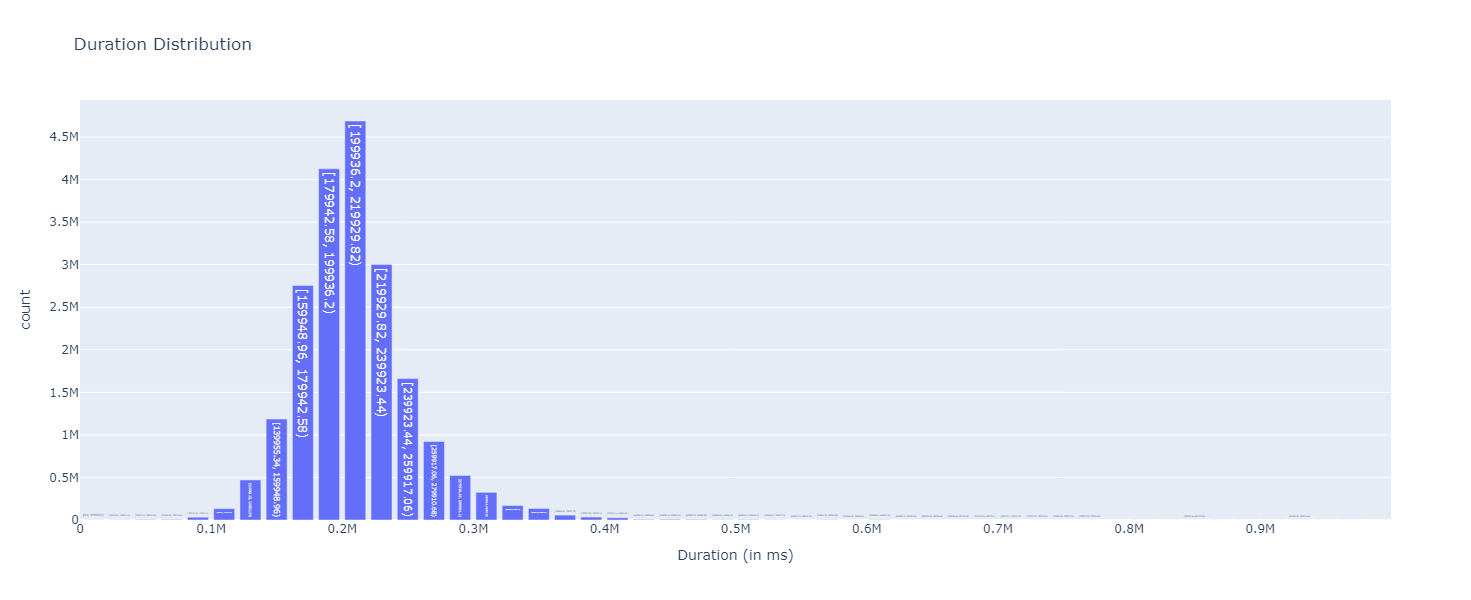

In [50]:
#histogram of duration distribution
#filter outliers for duration - for use in duration histogram only
df2_viz_dur = ps.DataFrame(df2.filter(df2.duration_ms < 1000000))
fig = df2_viz_dur["duration_ms"].plot.hist(bins = 50, alpha = 0.5)

fig.update_layout(width = 1000, height = 600, title = "Duration Distribution", xaxis_title = "Duration (in ms)")

fig.show()

The distibution of duration follows a normal distribution, not skewed to the left or right

In [51]:
#histogram of af_danceability distribution
fig = df2_viz["af_danceability"].plot.hist(bins = 50, alpha = 0.5)

fig.update_layout(width = 1000, height = 600, title = "AF_Danceability Distribution", xaxis_title = "AF_Danceability")

fig.show()

The distribution for the af danceability column is skewed to the left, and is a slight multimodal distribution as there are more than two distinct peaks in the distribution 

In [52]:
#histogram of af_energy distribution
fig = df2_viz["af_energy"].plot.hist(bins = 50, alpha = 0.5)

fig.update_layout(width = 1000, height = 600, title = "AF_Energy Distribution", xaxis_title = "AF_Energy")

fig.show()

The histogram for energy is skewed to the left and is a multi modal distribution, as there are more than two distinct peaks in this distribution 

In [53]:
#histogram of af_loudness distribution
fig = df2_viz["af_loudness"].plot.hist(bins = 50, alpha = 0.5)

fig.update_layout(width = 1000, height = 600, title = "AF_Loudness Distribution", xaxis_title = "AF_Loudness")

fig.show()

The distribution is skewed to the left and is a unimodal distribution, as there is one distinct peak in the distribution 

In [54]:
#histogram of af_speechiness distribution
fig = df2_viz["af_speechiness"].plot.hist(bins = 50, alpha = 0.5)

fig.update_layout(width = 1000, height = 600, title = "AF_Speechiness Distribution", xaxis_title = "AF_Speechiness")

fig.show()

The distribution for af speechiness is skewed to the right and this is a unimodal distribution, as there is one distinct peak 

In [55]:
#histogram of af_acousticness distribution
fig = df2_viz["af_acousticness"].plot.hist(bins = 50, alpha = 0.5)

fig.update_layout(width = 1000, height = 600, title = "AF_Acousticness Distribution", xaxis_title = "AF_Acousticness")

fig.show()

The disitrbution for af acuosticness is skewed to the right and this is a multimodal distribution, as there are several distinct peaks

In [56]:
#histogram of af_liveness distribution
fig = df2_viz["af_liveness"].plot.hist(bins = 50, alpha = 0.5)

fig.update_layout(width = 1000, height = 600, title = "AF_Liveness Distribution", xaxis_title = "AF_Liveness")

fig.show()

The distrubtion for af liveness is skewed to the right and this is a unimodal distribution, as there is one distinct peak in this distribution 

In [57]:
#histogram of af_valence distribution
fig = df2_viz["af_valence"].plot.hist(bins = 50, alpha = 0.5)

fig.update_layout(width = 1000, height = 600, title = "AF_Valence Distribution", xaxis_title = "AF_Valence")

fig.show()

The distrubtion isn't skewed in either direction and is a multimodal distribution, as there are more than two distinct peaks in this distribution 

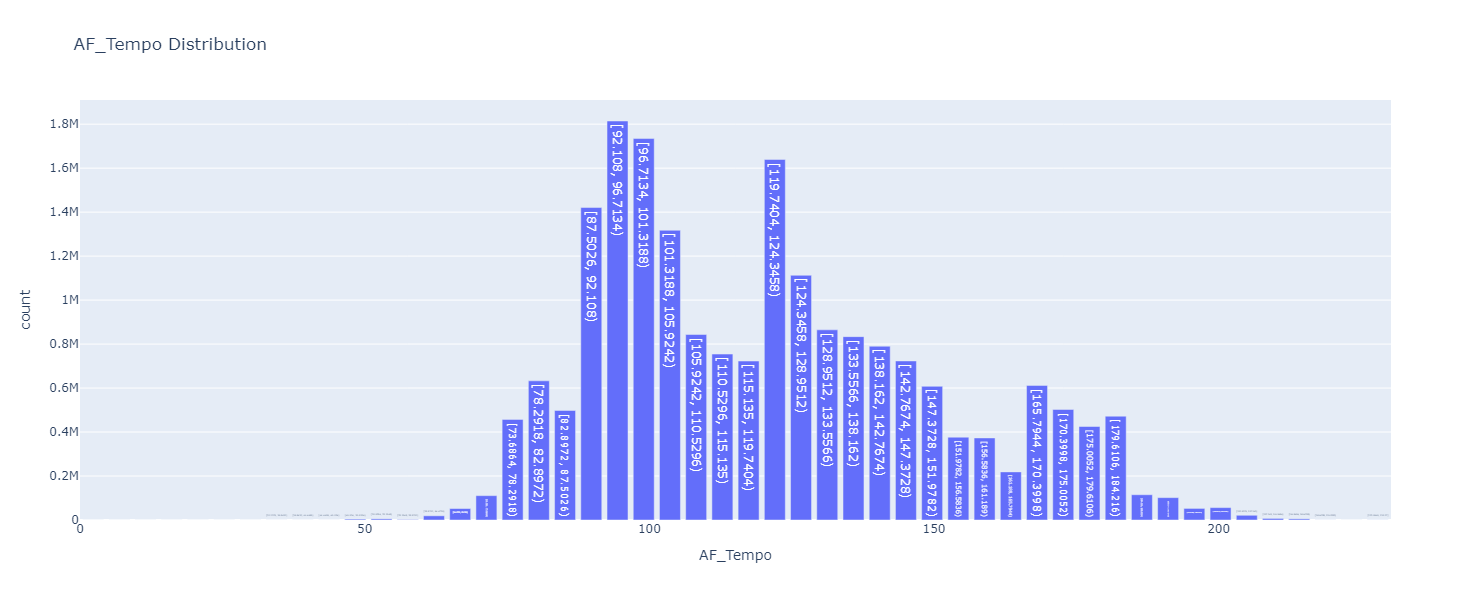

In [58]:
#histogram of af_tempo distribution
fig = df2_viz["af_tempo"].plot.hist(bins = 50, alpha = 0.5)

fig.update_layout(width = 1000, height = 600, title = "AF_Tempo Distribution", xaxis_title = "AF_Tempo")

fig.show()

The distribution is not skewed in either direction, and is a multi modal distribution, as there are more than two distinct peaks

## Data Pre Processing

In [8]:
#create column to transform explicit into 0,1
df3 = df2.withColumn("contains_cussing", \
               F.when((df2.explicit == True), F.lit(1))\
               .otherwise(F.lit(0)))

In [9]:
df3.show()

+---+--------------------+----+----------+--------------------+--------------------+---------+------+-------------+-------+--------------------+--------------------+----------+-----------+--------+------------+--------------------+---------------+---------+------+-----------+-------+--------------+---------------+-------------------+-----------+----------+--------+-----------------+----------------+
|_c0|               title|rank|      date|              artist|                 url|   region| chart|        trend|streams|            track_id|               album|popularity|duration_ms|explicit|release_date|   available_markets|af_danceability|af_energy|af_key|af_loudness|af_mode|af_speechiness|af_acousticness|af_instrumentalness|af_liveness|af_valence|af_tempo|af_time_signature|contains_cussing|
+---+--------------------+----+----------+--------------------+--------------------+---------+------+-------------+-------+--------------------+--------------------+----------+-----------+------

In [61]:
df3.select("contains_cussing").show()

+----------------+
|contains_cussing|
+----------------+
|               0|
|               0|
|               0|
|               0|
|               0|
|               0|
|               0|
|               0|
|               0|
|               0|
|               0|
|               0|
|               0|
|               0|
|               0|
|               0|
|               0|
|               0|
|               0|
|               0|
+----------------+
only showing top 20 rows



In [9]:
#create column to transform popularity increase into 0,1
df3 = df3.withColumn("popularity_increased", \
                    F.when((df3.trend == "MOVE_UP"), F.lit(1))\
                    .otherwise(F.lit(0)))

In [11]:
df3.select("popularity_increased").show()

+--------------------+
|popularity_increased|
+--------------------+
|                   0|
|                   1|
|                   0|
|                   0|
|                   1|
|                   0|
|                   0|
|                   0|
|                   1|
|                   0|
|                   0|
|                   1|
|                   1|
|                   0|
|                   0|
|                   1|
|                   1|
|                   0|
|                   0|
|                   0|
+--------------------+
only showing top 20 rows



In [10]:
#create column to transform popularity decrease into 0,1
df3 = df3.withColumn("popularity_decreased", \
                    F.when((df3.trend == "MOVE_DOWN"), F.lit(1))\
                    .otherwise(F.lit(0)))

In [13]:
df3.select("popularity_decreased").show()

+--------------------+
|popularity_decreased|
+--------------------+
|                   0|
|                   0|
|                   1|
|                   0|
|                   0|
|                   1|
|                   1|
|                   1|
|                   0|
|                   1|
|                   0|
|                   0|
|                   0|
|                   1|
|                   1|
|                   0|
|                   0|
|                   1|
|                   0|
|                   1|
+--------------------+
only showing top 20 rows



In [11]:
#create column to transform same popularity into 0,1
df3 = df3.withColumn("populairty_same", \
                    F.when((df3.trend == "SAME_POSITION"), F.lit(1))\
                    .otherwise(F.lit(0)))

In [15]:
df3.select("populairty_same").show()

+---------------+
|populairty_same|
+---------------+
|              1|
|              0|
|              0|
|              1|
|              0|
|              0|
|              0|
|              0|
|              0|
|              0|
|              1|
|              0|
|              0|
|              0|
|              0|
|              0|
|              0|
|              0|
|              1|
|              0|
+---------------+
only showing top 20 rows



In [12]:
#create column to transform new entry into 0,1
df3 = df3.withColumn("new_entry", \
                    F.when((df3.trend == "NEW_ENTRY"), F.lit(1))\
                    .otherwise(F.lit(0)))

In [17]:
df3.select("new_entry").show()

+---------+
|new_entry|
+---------+
|        0|
|        0|
|        0|
|        0|
|        0|
|        0|
|        0|
|        0|
|        0|
|        0|
|        0|
|        0|
|        0|
|        0|
|        0|
|        0|
|        0|
|        0|
|        0|
|        0|
+---------+
only showing top 20 rows



### Normalization of Select Fields

Reviewing our data distribution visualizations above, it is apparent that a handful distributions do not follow a normal guassian distribution, and should therefore be normalized for our machine learning procedures to follow.

In [13]:
#normalize af_acousticness
af_acousticness_min = df3.select(F.min(F.col("af_acousticness"))).collect()[0][0]
af_acousticness_max = df3.select(F.max(F.col("af_acousticness"))).collect()[0][0]
df3_normalized = df3.withColumn("af_acousticness_normalized", (F.col("af_acousticness") - af_acousticness_min) / (af_acousticness_max - af_acousticness_min))

In [19]:
df3_normalized.select("af_acousticness_normalized").show()

+--------------------------+
|af_acousticness_normalized|
+--------------------------+
|       0.18775100401606426|
|      0.004327309236947791|
|       0.40160642570281124|
|        0.5532128514056225|
|       0.07630522088353414|
|         0.142570281124498|
|       0.08544176706827308|
|       0.05612449799196787|
|       0.19879518072289157|
|       0.10020080321285141|
|      0.024497991967871488|
|       0.17168674698795183|
|       0.13253012048192772|
|       0.06757028112449799|
|        0.5491967871485944|
|       0.11746987951807229|
|       0.08614457831325302|
|         0.078714859437751|
|       0.12650602409638553|
|       0.25702811244979923|
+--------------------------+
only showing top 20 rows



In [14]:
#normalize af_loudness
af_loudness_min = df3.select(F.min(F.col("af_loudness"))).collect()[0][0]
af_loudness_max = df3.select(F.max(F.col("af_loudness"))).collect()[0][0]
df3_normalized = df3.withColumn("af_loudness_normalized", (F.col("af_loudness") - af_loudness_min) / (af_loudness_max - af_loudness_min))

In [21]:
df3_normalized.select("af_loudness_normalized").show()

+----------------------+
|af_loudness_normalized|
+----------------------+
|    0.9174328147100425|
|     0.898964896489649|
|    0.9149897132570399|
|    0.8942876430500193|
|    0.8964253568213963|
|      0.88509386652951|
|    0.8491545583129742|
|     0.877121640735502|
|    0.9298733444773049|
|    0.8569821267841069|
|    0.9350810081008101|
|    0.9525041789893275|
|    0.8697923363764948|
|    0.8998167673910248|
|    0.9028545711714028|
|    0.9088498135527838|
|    0.9120804937636621|
|     0.879050405040504|
|    0.8971164973640221|
|    0.9125466118040375|
+----------------------+
only showing top 20 rows



In [22]:
df3_normalized.show()

+---+--------------------+----+----------+--------------------+--------------------+---------+------+-------------+-------+--------------------+--------------------+----------+-----------+--------+------------+--------------------+---------------+---------+------+-----------+-------+--------------+---------------+-------------------+-----------+----------+--------+-----------------+----------------+--------------------+--------------------+---------------+---------+----------------------+
|_c0|               title|rank|      date|              artist|                 url|   region| chart|        trend|streams|            track_id|               album|popularity|duration_ms|explicit|release_date|   available_markets|af_danceability|af_energy|af_key|af_loudness|af_mode|af_speechiness|af_acousticness|af_instrumentalness|af_liveness|af_valence|af_tempo|af_time_signature|contains_cussing|popularity_increased|popularity_decreased|populairty_same|new_entry|af_loudness_normalized|
+---+-------

## Machine Learning Experiments

### Random Forest Classification Models
#### Create a random forest classification model to determine if profanity in a song can be classified using other variables

In [75]:
#create classification dataframe with desired fields
classification = df3_normalized.select("af_danceability", "af_energy", "af_loudness", "af_speechiness", "af_acousticness", "af_liveness", "af_valence", "af_tempo", "contains_cussing")
classification.show()

+---------------+---------+-----------+--------------+---------------+-----------+----------+--------+----------------+
|af_danceability|af_energy|af_loudness|af_speechiness|af_acousticness|af_liveness|af_valence|af_tempo|contains_cussing|
+---------------+---------+-----------+--------------+---------------+-----------+----------+--------+----------------+
|          0.852|    0.773|     -2.921|        0.0776|          0.187|      0.159|     0.907| 102.034|               0|
|          0.663|     0.92|      -4.07|         0.226|        0.00431|      0.101|     0.533|  99.935|               0|
|          0.761|    0.838|     -3.073|        0.0502|            0.4|      0.176|      0.71|  93.974|               0|
|          0.508|    0.687|     -4.361|         0.326|          0.551|      0.126|     0.555| 180.044|               0|
|          0.899|    0.626|     -4.228|         0.292|          0.076|     0.0631|     0.873|  88.007|               0|
|          0.776|    0.669|     -4.933| 

In [76]:
#create list of required features
required_features = ["af_danceability", "af_energy", "af_loudness", "af_speechiness", "af_acousticness", "af_liveness", "af_valence", "af_tempo"]

In [77]:
#create features field using vector assembler
assembler = VectorAssembler(inputCols=required_features, outputCol="features")
transformed_data = assembler.transform(classification)
transformed_data.show()

+---------------+---------+-----------+--------------+---------------+-----------+----------+--------+----------------+--------------------+
|af_danceability|af_energy|af_loudness|af_speechiness|af_acousticness|af_liveness|af_valence|af_tempo|contains_cussing|            features|
+---------------+---------+-----------+--------------+---------------+-----------+----------+--------+----------------+--------------------+
|          0.852|    0.773|     -2.921|        0.0776|          0.187|      0.159|     0.907| 102.034|               0|[0.852,0.773,-2.9...|
|          0.663|     0.92|      -4.07|         0.226|        0.00431|      0.101|     0.533|  99.935|               0|[0.663,0.92,-4.07...|
|          0.761|    0.838|     -3.073|        0.0502|            0.4|      0.176|      0.71|  93.974|               0|[0.761,0.838,-3.0...|
|          0.508|    0.687|     -4.361|         0.326|          0.551|      0.126|     0.555| 180.044|               0|[0.508,0.687,-4.3...|
|          0.

In [78]:
#create training and test data sets from full data
training_data, test_data = transformed_data.randomSplit([0.75, 0.25])

In [79]:
training_data

DataFrame[af_danceability: double, af_energy: double, af_loudness: double, af_speechiness: double, af_acousticness: double, af_liveness: double, af_valence: double, af_tempo: double, contains_cussing: int, features: vector]

In [80]:
test_data

DataFrame[af_danceability: double, af_energy: double, af_loudness: double, af_speechiness: double, af_acousticness: double, af_liveness: double, af_valence: double, af_tempo: double, contains_cussing: int, features: vector]

In [82]:
#create random forest model
rf = RandomForestClassifier(labelCol="contains_cussing", featuresCol="features", maxDepth=5, numTrees=10)

In [83]:
#train model
model = rf.fit(training_data)

In [84]:
#use trainined model to generate predictions
rf_predictions = model.transform(test_data)

In [87]:
#evaluate predictions
multi_evaluator = MulticlassClassificationEvaluator(labelCol="contains_cussing", metricName="accuracy")
print("Random Forest Classifier Accuracy on Profanity Prediction:", multi_evaluator.evaluate(rf_predictions))

Random Forest Classifier Accuracy on Profanity Prediction: 0.7742151848914597


**Our random forest classifier for prediction of profanity has an accuracy of 77.4%**

#### Create a random forest classification model to determine if popularity increase in a song can be classified using other variables

In [91]:
#create classification dataframe with desired fields
classification2 = df3_normalized.select("af_danceability", "af_energy", "af_loudness", "af_speechiness", "af_acousticness", "af_liveness", "af_valence", "af_tempo", "popularity_increased")
classification2.show()

+---------------+---------+-----------+--------------+---------------+-----------+----------+--------+--------------------+
|af_danceability|af_energy|af_loudness|af_speechiness|af_acousticness|af_liveness|af_valence|af_tempo|popularity_increased|
+---------------+---------+-----------+--------------+---------------+-----------+----------+--------+--------------------+
|          0.852|    0.773|     -2.921|        0.0776|          0.187|      0.159|     0.907| 102.034|                   0|
|          0.663|     0.92|      -4.07|         0.226|        0.00431|      0.101|     0.533|  99.935|                   1|
|          0.761|    0.838|     -3.073|        0.0502|            0.4|      0.176|      0.71|  93.974|                   0|
|          0.508|    0.687|     -4.361|         0.326|          0.551|      0.126|     0.555| 180.044|                   0|
|          0.899|    0.626|     -4.228|         0.292|          0.076|     0.0631|     0.873|  88.007|                   1|
|       

In [92]:
#create list of required features
required_features2 = ["af_danceability", "af_energy", "af_loudness", "af_speechiness", "af_acousticness", "af_liveness", "af_valence", "af_tempo"]

In [93]:
#create features field using vector assembler
assembler2 = VectorAssembler(inputCols=required_features2, outputCol="features")
transformed_data2 = assembler.transform(classification2)
transformed_data2.show()

+---------------+---------+-----------+--------------+---------------+-----------+----------+--------+--------------------+--------------------+
|af_danceability|af_energy|af_loudness|af_speechiness|af_acousticness|af_liveness|af_valence|af_tempo|popularity_increased|            features|
+---------------+---------+-----------+--------------+---------------+-----------+----------+--------+--------------------+--------------------+
|          0.852|    0.773|     -2.921|        0.0776|          0.187|      0.159|     0.907| 102.034|                   0|[0.852,0.773,-2.9...|
|          0.663|     0.92|      -4.07|         0.226|        0.00431|      0.101|     0.533|  99.935|                   1|[0.663,0.92,-4.07...|
|          0.761|    0.838|     -3.073|        0.0502|            0.4|      0.176|      0.71|  93.974|                   0|[0.761,0.838,-3.0...|
|          0.508|    0.687|     -4.361|         0.326|          0.551|      0.126|     0.555| 180.044|                   0|[0.508,

In [94]:
#create training and test data sets from full data
training_data2, test_data2 = transformed_data2.randomSplit([0.75, 0.25])

In [95]:
#create random forest model
rf2 = RandomForestClassifier(labelCol="popularity_increased", featuresCol="features", maxDepth=5, numTrees=10)

In [96]:
#train model
model2 = rf2.fit(training_data2)

In [97]:
#use trainined model to generate predictions
rf_predictions2 = model2.transform(test_data2)

In [98]:
#evaluate predictions
multi_evaluator2 = MulticlassClassificationEvaluator(labelCol="popularity_increased", metricName="accuracy")
print("Random Forest Classifier Accuracy on Popularity Increase Prediction:", multi_evaluator2.evaluate(rf_predictions2))

Random Forest Classifier Accuracy on Popularity Increase Prediction: 0.6146065336034363


**Our random forest classifier for prediction of popularity increase has an accuracy of 61.5%**

#### Create a random forest classification model to determine if popularity decrease in a song can be classified using other variables

In [99]:
#create classification dataframe with desired fields
classification3 = df3_normalized.select("af_danceability", "af_energy", "af_loudness", "af_speechiness", "af_acousticness", "af_liveness", "af_valence", "af_tempo", "popularity_decreased")

In [100]:
#create list of required features
required_features3 = ["af_danceability", "af_energy", "af_loudness", "af_speechiness", "af_acousticness", "af_liveness", "af_valence", "af_tempo"]

In [101]:
#create features field using vector assembler
assembler3 = VectorAssembler(inputCols=required_features3, outputCol="features")
transformed_data3 = assembler.transform(classification3)
transformed_data3.show()

+---------------+---------+-----------+--------------+---------------+-----------+----------+--------+--------------------+--------------------+
|af_danceability|af_energy|af_loudness|af_speechiness|af_acousticness|af_liveness|af_valence|af_tempo|popularity_decreased|            features|
+---------------+---------+-----------+--------------+---------------+-----------+----------+--------+--------------------+--------------------+
|          0.852|    0.773|     -2.921|        0.0776|          0.187|      0.159|     0.907| 102.034|                   0|[0.852,0.773,-2.9...|
|          0.663|     0.92|      -4.07|         0.226|        0.00431|      0.101|     0.533|  99.935|                   0|[0.663,0.92,-4.07...|
|          0.761|    0.838|     -3.073|        0.0502|            0.4|      0.176|      0.71|  93.974|                   1|[0.761,0.838,-3.0...|
|          0.508|    0.687|     -4.361|         0.326|          0.551|      0.126|     0.555| 180.044|                   0|[0.508,

In [102]:
#create training and test data sets from full data
training_data3, test_data3 = transformed_data3.randomSplit([0.75, 0.25])

In [103]:
#create random forest model
rf3 = RandomForestClassifier(labelCol="popularity_decreased", featuresCol="features", maxDepth=5, numTrees=10)

In [104]:
#train model
model3 = rf3.fit(training_data3)

In [105]:
#use trainined model to generate predictions
rf_predictions3 = model3.transform(test_data3)

In [107]:
#evaluate predictions
multi_evaluator3 = MulticlassClassificationEvaluator(labelCol="popularity_decreased", metricName="accuracy")
print("Random Forest Classifier Accuracy on Popularity Decrease Prediction:", multi_evaluator3.evaluate(rf_predictions3))

Random Forest Classifier Accuracy on Popularity Decrease Prediction: 0.5584375295452396


**Our random forest classifier for prediction of popularity increase has an accuracy of 55.8%**

#### Create a random forest classification model to determine if the same popularity for a song can be classified using other variables

In [108]:
#create classification dataframe with desired fields
classification4 = df3_normalized.select("af_danceability", "af_energy", "af_loudness", "af_speechiness", "af_acousticness", "af_liveness", "af_valence", "af_tempo", "populairty_same")

In [109]:
#create list of required features
required_features4 = ["af_danceability", "af_energy", "af_loudness", "af_speechiness", "af_acousticness", "af_liveness", "af_valence", "af_tempo"]

In [110]:
#create features field using vector assembler
assembler4 = VectorAssembler(inputCols=required_features4, outputCol="features")
transformed_data4 = assembler.transform(classification4)
transformed_data4.show()

+---------------+---------+-----------+--------------+---------------+-----------+----------+--------+---------------+--------------------+
|af_danceability|af_energy|af_loudness|af_speechiness|af_acousticness|af_liveness|af_valence|af_tempo|populairty_same|            features|
+---------------+---------+-----------+--------------+---------------+-----------+----------+--------+---------------+--------------------+
|          0.852|    0.773|     -2.921|        0.0776|          0.187|      0.159|     0.907| 102.034|              1|[0.852,0.773,-2.9...|
|          0.663|     0.92|      -4.07|         0.226|        0.00431|      0.101|     0.533|  99.935|              0|[0.663,0.92,-4.07...|
|          0.761|    0.838|     -3.073|        0.0502|            0.4|      0.176|      0.71|  93.974|              0|[0.761,0.838,-3.0...|
|          0.508|    0.687|     -4.361|         0.326|          0.551|      0.126|     0.555| 180.044|              1|[0.508,0.687,-4.3...|
|          0.899|   

In [111]:
#create training and test data sets from full data
training_data4, test_data4 = transformed_data4.randomSplit([0.75, 0.25])

In [112]:
#create random forest model
rf4 = RandomForestClassifier(labelCol="populairty_same", featuresCol="features", maxDepth=5, numTrees=10)

In [113]:
#train model
model4 = rf4.fit(training_data4)

In [114]:
#use trainined model to generate predictions
rf_predictions4 = model4.transform(test_data4)

In [115]:
#evaluate predictions
multi_evaluator4 = MulticlassClassificationEvaluator(labelCol="populairty_same", metricName="accuracy")
print("Random Forest Classifier Accuracy on the same Popularity Prediction:", multi_evaluator4.evaluate(rf_predictions4))

Random Forest Classifier Accuracy on the same Popularity Prediction: 0.8849586921379282


**Our random forest classifier for prediction of popularity remaining the same has an accuracy of 88.4%**

#### Create a random forest classification model to determine if a new popularity entry for a song can be classified using other variables

In [116]:
#create classification dataframe with desired fields
classification5 = df3_normalized.select("af_danceability", "af_energy", "af_loudness", "af_speechiness", "af_acousticness", "af_liveness", "af_valence", "af_tempo", "new_entry")

In [117]:
#create list of required features
required_features5 = ["af_danceability", "af_energy", "af_loudness", "af_speechiness", "af_acousticness", "af_liveness", "af_valence", "af_tempo"]

In [118]:
#create features field using vector assembler
assembler5 = VectorAssembler(inputCols=required_features5, outputCol="features")
transformed_data5 = assembler.transform(classification5)
transformed_data5.show()

+---------------+---------+-----------+--------------+---------------+-----------+----------+--------+---------+--------------------+
|af_danceability|af_energy|af_loudness|af_speechiness|af_acousticness|af_liveness|af_valence|af_tempo|new_entry|            features|
+---------------+---------+-----------+--------------+---------------+-----------+----------+--------+---------+--------------------+
|          0.852|    0.773|     -2.921|        0.0776|          0.187|      0.159|     0.907| 102.034|        0|[0.852,0.773,-2.9...|
|          0.663|     0.92|      -4.07|         0.226|        0.00431|      0.101|     0.533|  99.935|        0|[0.663,0.92,-4.07...|
|          0.761|    0.838|     -3.073|        0.0502|            0.4|      0.176|      0.71|  93.974|        0|[0.761,0.838,-3.0...|
|          0.508|    0.687|     -4.361|         0.326|          0.551|      0.126|     0.555| 180.044|        0|[0.508,0.687,-4.3...|
|          0.899|    0.626|     -4.228|         0.292|        

In [119]:
#create training and test data sets from full data
training_data5, test_data5 = transformed_data5.randomSplit([0.75, 0.25])

In [120]:
#create random forest model
rf5 = RandomForestClassifier(labelCol="new_entry", featuresCol="features", maxDepth=5, numTrees=10)

In [122]:
#train model
model5 = rf5.fit(training_data5)

In [123]:
#use trainined model to generate predictions
rf_predictions5 = model5.transform(test_data5)

In [125]:
#evaluate predictions
multi_evaluator5 = MulticlassClassificationEvaluator(labelCol="new_entry", metricName="accuracy")
print("Random Forest Classifier Accuracy on New Entry Prediction:", multi_evaluator5.evaluate(rf_predictions5))

Random Forest Classifier Accuracy on New Entry Prediction: 0.9420154382372053


**Our random forest classifier for prediction of a new popularity entry has an accuracy of 94.2%**

### K-means Clustering Models

Due to the size of our dataset, we will run the clustering analysis on a sample

#### Energy and danceability clustering

In [37]:
#create sampled dataframe of 25% of the full dataset
df3_normalized_sample = df3_normalized.sample(fraction=0.05)

In [38]:
#create dataframe with desired fields for clustering
cluster1 = df3_normalized_sample.select("af_energy", "af_danceability")

In [39]:
#create list of required features
required_featuresC1 = ["af_energy", "af_danceability"]

In [40]:
#create features field using vector assembler
assemblerC1 = VectorAssembler(inputCols=required_featuresC1, outputCol="features")
transformed_dataC1 = assemblerC1.transform(cluster1)
transformed_dataC1.show()

+---------+---------------+-------------+
|af_energy|af_danceability|     features|
+---------+---------------+-------------+
|    0.626|          0.899|[0.626,0.899]|
|    0.605|          0.837|[0.605,0.837]|
|    0.733|          0.652|[0.733,0.652]|
|    0.702|          0.614|[0.702,0.614]|
|    0.929|          0.723|[0.929,0.723]|
|    0.618|          0.754|[0.618,0.754]|
|    0.877|          0.746|[0.877,0.746]|
|    0.802|          0.721|[0.802,0.721]|
|    0.455|          0.637|[0.455,0.637]|
|    0.838|           0.67| [0.838,0.67]|
|    0.633|          0.636|[0.633,0.636]|
|     0.83|          0.666| [0.83,0.666]|
|    0.738|          0.648|[0.738,0.648]|
|    0.774|           0.68| [0.774,0.68]|
|    0.764|          0.774|[0.764,0.774]|
|    0.445|          0.781|[0.445,0.781]|
|    0.773|          0.852|[0.773,0.852]|
|    0.657|          0.884|[0.657,0.884]|
|    0.974|          0.727|[0.974,0.727]|
|    0.671|          0.779|[0.671,0.779]|
+---------+---------------+-------

In [41]:
#scale features for proper clustering
scalerC1 = StandardScaler(inputCol="features", outputCol="scaled_features")
scaler_modelC1 = scalerC1.fit(transformed_dataC1)
transformed_dataC1 = scaler_modelC1.transform(transformed_dataC1)

In [42]:
#create wssse scoring list and clustering evaluator
wssse_valuesC1 = []
evaluatorC1 = ClusteringEvaluator()

In [43]:
#run multiple k clustering analysis to determine best k number of clusters, evaluate scores for each
for i in range(2,10):    
    KMeans_modC1 = KMeans(featuresCol='scaled_features', k=i)  
    KMeans_fitC1 = KMeans_modC1.fit(transformed_dataC1)  
    outputC1 = KMeans_fitC1.transform(transformed_dataC1)   
    scoreC1 = evaluatorC1.evaluate(outputC1)   
    wssse_valuesC1.append(scoreC1)  
    print("Silhouette Score:",scoreC1)

Silhouette Score: 0.5492704788609065
Silhouette Score: 0.5173897338891734
Silhouette Score: 0.5029666184535027
Silhouette Score: 0.46515254881357165
Silhouette Score: 0.4442161457724867
Silhouette Score: 0.4735004919145314
Silhouette Score: 0.4755510964656044
Silhouette Score: 0.45684214759467057


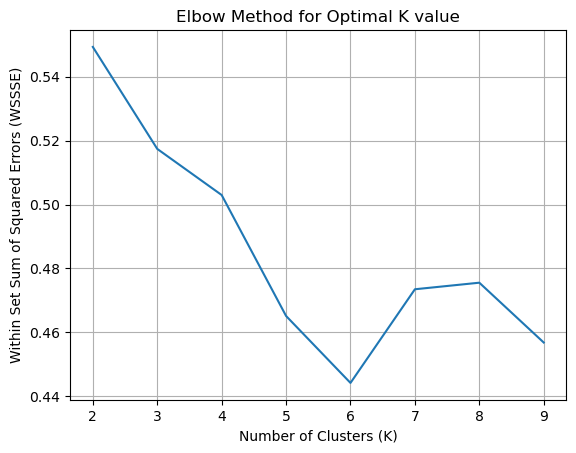

In [44]:
#visualize scores across each k number of clusters
plt.plot(range(2, 10), wssse_valuesC1)
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Within Set Sum of Squared Errors (WSSSE)")
plt.title("Elbow Method for Optimal K value")
plt.grid()
plt.show()

Based on this analysis, we will choose 6 clusters

In [46]:
#run cluster model with 6 clusters for further analysis
kmeansC1 = KMeans(k=6, featuresCol="scaled_features", predictionCol="cluster")
kmeans_modelC1 = kmeansC1.fit(transformed_dataC1)
clustered_dataC1 = kmeans_modelC1.transform(transformed_dataC1)

In [47]:
clustered_dataC1.show()

+---------+---------------+-------------+--------------------+-------+
|af_energy|af_danceability|     features|     scaled_features|cluster|
+---------+---------------+-------------+--------------------+-------+
|    0.626|          0.899|[0.626,0.899]|[3.84403474373483...|      3|
|    0.605|          0.837|[0.605,0.837]|[3.71508150153286...|      3|
|    0.733|          0.652|[0.733,0.652]|[4.50108221590676...|      1|
|    0.702|          0.614|[0.702,0.614]|[4.31072266789433...|      2|
|    0.929|          0.723|[0.929,0.723]|[5.70464580979179...|      1|
|    0.618|          0.754|[0.618,0.754]|[3.79490969908646...|      5|
|    0.877|          0.746|[0.877,0.746]|[5.38533301957739...|      1|
|    0.802|          0.721|[0.802,0.721]|[4.92478572599894...|      1|
|    0.455|          0.637|[0.455,0.637]|[2.79398691437595...|      4|
|    0.838|           0.67| [0.838,0.67]|[5.14584842691660...|      1|
|    0.633|          0.636|[0.633,0.636]|[3.88701915780215...|      2|
|     

In [54]:
#convert to a pandas dataframe for cluster visualization work
dfC_viz = clustered_dataC1.toPandas()

In [56]:
#plot energy and danceability cluster analysis
plt.scatter(dfC_viz["af_energy"], dfC_viz["af_danceability"], c=dfC_viz["cluster"])
plt.xlabel("af_energy")
plt.ylabel("af_danceability")
plt.title("K-Means Cluster with af_energy and af_danceability")
plt.colorbar().set_label("Cluster")
plt.show()

#### Popularity and danceability clustering

In [57]:
#create dataframe with desired fields for clustering
cluster2 = df3_normalized_sample.select("popularity", "af_danceability")

In [58]:
#create list of required features
required_featuresC2 = ["popularity", "af_danceability"]

In [59]:
#create features field using vector assembler
assemblerC2 = VectorAssembler(inputCols=required_featuresC2, outputCol="features")
transformed_dataC2 = assemblerC2.transform(cluster2)
transformed_dataC2.show()

+----------+---------------+------------+
|popularity|af_danceability|    features|
+----------+---------------+------------+
|         0|          0.899| [0.0,0.899]|
|        54|          0.837|[54.0,0.837]|
|        45|          0.652|[45.0,0.652]|
|        60|          0.614|[60.0,0.614]|
|        47|          0.723|[47.0,0.723]|
|        50|          0.754|[50.0,0.754]|
|         0|          0.746| [0.0,0.746]|
|        85|          0.721|[85.0,0.721]|
|        63|          0.637|[63.0,0.637]|
|        41|           0.67| [41.0,0.67]|
|         0|          0.636| [0.0,0.636]|
|        80|          0.666|[80.0,0.666]|
|         5|          0.648| [5.0,0.648]|
|         0|           0.68|  [0.0,0.68]|
|         0|          0.774| [0.0,0.774]|
|        65|          0.781|[65.0,0.781]|
|        78|          0.852|[78.0,0.852]|
|        76|          0.884|[76.0,0.884]|
|        84|          0.727|[84.0,0.727]|
|         0|          0.779| [0.0,0.779]|
+----------+---------------+------

In [60]:
#scale features for proper clustering
scalerC2 = StandardScaler(inputCol="features", outputCol="scaled_features")
scaler_modelC2 = scalerC2.fit(transformed_dataC2)
transformed_dataC2 = scaler_modelC2.transform(transformed_dataC2)

In [61]:
#create wssse scoring list and clustering evaluator
wssse_valuesC2 = []
evaluatorC2 = ClusteringEvaluator()

In [62]:
#run multiple k clustering analysis to determine best k number of clusters, evaluate scores for each
for i in range(2,10):    
    KMeans_modC2 = KMeans(featuresCol='scaled_features', k=i)  
    KMeans_fitC2 = KMeans_modC2.fit(transformed_dataC2)  
    outputC2 = KMeans_fitC2.transform(transformed_dataC2)   
    scoreC2 = evaluatorC2.evaluate(outputC2)   
    wssse_valuesC2.append(scoreC2)  
    print("Silhouette Score:",scoreC2)

Silhouette Score: 0.8785532878495226
Silhouette Score: 0.3273972588970275
Silhouette Score: 0.028365477837013767
Silhouette Score: -0.01873459539871663
Silhouette Score: -0.020683535499144846
Silhouette Score: -0.03338390033915237
Silhouette Score: -0.06254580484007226
Silhouette Score: -0.20195852169121722


In [63]:
#visualize scores across each k number of clusters
plt.plot(range(2, 10), wssse_valuesC2)
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Within Set Sum of Squared Errors (WSSSE)")
plt.title("Elbow Method for Optimal K value")
plt.grid()
plt.show()

Based on this analysis, we will choose 4 clusters

In [64]:
#run cluster model with 4 clusters for further analysis
kmeansC2 = KMeans(k=4, featuresCol="scaled_features", predictionCol="cluster")
kmeans_modelC2 = kmeansC2.fit(transformed_dataC2)
clustered_dataC2 = kmeans_modelC2.transform(transformed_dataC2)

In [65]:
clustered_dataC2.show()

+----------+---------------+------------+--------------------+-------+
|popularity|af_danceability|    features|     scaled_features|cluster|
+----------+---------------+------------+--------------------+-------+
|         0|          0.899| [0.0,0.899]|[0.0,6.7176202354...|      3|
|        54|          0.837|[54.0,0.837]|[1.77217050427432...|      1|
|        45|          0.652|[45.0,0.652]|[1.47680875356193...|      1|
|        60|          0.614|[60.0,0.614]|[1.96907833808257...|      2|
|        47|          0.723|[47.0,0.723]|[1.54244469816468...|      1|
|        50|          0.754|[50.0,0.754]|[1.64089861506881...|      1|
|         0|          0.746| [0.0,0.746]|[0.0,5.5743545001...|      3|
|        85|          0.721|[85.0,0.721]|[2.78952764561698...|      1|
|        63|          0.637|[63.0,0.637]|[2.06753225498670...|      2|
|        41|           0.67| [41.0,0.67]|[1.34553686435642...|      1|
|         0|          0.636| [0.0,0.636]|[0.0,4.7523987427...|      0|
|     

In [66]:
#convert to a pandas dataframe for cluster visualization work
dfC_viz = clustered_dataC2.toPandas()

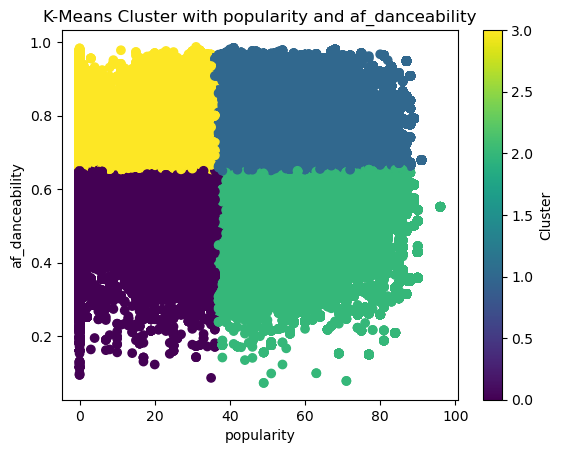

In [68]:
#plot popularity and danceability cluster analysis
plt.scatter(dfC_viz["popularity"], dfC_viz["af_danceability"], c=dfC_viz["cluster"])
plt.xlabel("popularity")
plt.ylabel("af_danceability")
plt.title("K-Means Cluster with popularity and af_danceability")
plt.colorbar().set_label("Cluster")
plt.show()

#### Popularity and valence clustering

In [69]:
#create dataframe with desired fields for clustering
cluster3 = df3_normalized_sample.select("popularity", "af_valence")

In [70]:
#create list of required features
required_featuresC3 = ["popularity", "af_valence"]

In [71]:
#create features field using vector assembler
assemblerC3 = VectorAssembler(inputCols=required_featuresC3, outputCol="features")
transformed_dataC3 = assemblerC3.transform(cluster3)
transformed_dataC3.show()

+----------+----------+------------+
|popularity|af_valence|    features|
+----------+----------+------------+
|         0|     0.873| [0.0,0.873]|
|        54|     0.723|[54.0,0.723]|
|        45|     0.754|[45.0,0.754]|
|        60|     0.851|[60.0,0.851]|
|        47|     0.812|[47.0,0.812]|
|        50|     0.477|[50.0,0.477]|
|         0|     0.751| [0.0,0.751]|
|        85|     0.724|[85.0,0.724]|
|        63|     0.619|[63.0,0.619]|
|        41|     0.717|[41.0,0.717]|
|         0|     0.512| [0.0,0.512]|
|        80|     0.702|[80.0,0.702]|
|         5|     0.603| [5.0,0.603]|
|         0|     0.331| [0.0,0.331]|
|         0|     0.912| [0.0,0.912]|
|        65|     0.591|[65.0,0.591]|
|        78|     0.907|[78.0,0.907]|
|        76|     0.489|[76.0,0.489]|
|        84|     0.965|[84.0,0.965]|
|         0|     0.718| [0.0,0.718]|
+----------+----------+------------+
only showing top 20 rows



In [72]:
#scale features for proper clustering
scalerC3 = StandardScaler(inputCol="features", outputCol="scaled_features")
scaler_modelC3 = scalerC3.fit(transformed_dataC3)
transformed_dataC3 = scaler_modelC3.transform(transformed_dataC3)

In [73]:
#create wssse scoring list and clustering evaluator
wssse_valuesC3 = []
evaluatorC3 = ClusteringEvaluator()

In [74]:
#run multiple k clustering analysis to determine best k number of clusters, evaluate scores for each
for i in range(2,10):    
    KMeans_modC3 = KMeans(featuresCol='scaled_features', k=i)  
    KMeans_fitC3 = KMeans_modC3.fit(transformed_dataC3)  
    outputC3 = KMeans_fitC3.transform(transformed_dataC3)   
    scoreC3 = evaluatorC3.evaluate(outputC3)   
    wssse_valuesC3.append(scoreC3)  
    print("Silhouette Score:",scoreC3)

Silhouette Score: 0.8777958005670929
Silhouette Score: 0.25316260737768
Silhouette Score: 0.008758324455058466
Silhouette Score: -0.025610898137982625
Silhouette Score: -0.03723946929681865
Silhouette Score: -0.10253902231710126
Silhouette Score: -0.09296600779895305
Silhouette Score: -0.10702128533420957


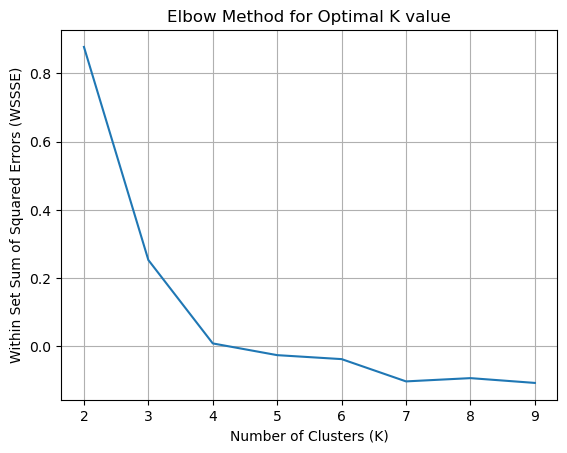

In [89]:
#visualize scores across each k number of clusters
plt.plot(range(2, 10), wssse_valuesC3)
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Within Set Sum of Squared Errors (WSSSE)")
plt.title("Elbow Method for Optimal K value")
plt.grid()
plt.show()

Based on this analysis, we will choose 4 clusters

In [85]:
#run cluster model with 4 clusters for further analysis
kmeansC3 = KMeans(k=4, featuresCol="scaled_features", predictionCol="cluster")
kmeans_modelC3 = kmeansC3.fit(transformed_dataC3)
clustered_dataC3 = kmeans_modelC3.transform(transformed_dataC3)

In [86]:
clustered_dataC3.show()

+----------+----------+------------+--------------------+-------+
|popularity|af_valence|    features|     scaled_features|cluster|
+----------+----------+------------+--------------------+-------+
|         0|     0.873| [0.0,0.873]|[0.0,3.9439612066...|      2|
|        54|     0.723|[54.0,0.723]|[1.77217050427432...|      0|
|        45|     0.754|[45.0,0.754]|[1.47680875356193...|      0|
|        60|     0.851|[60.0,0.851]|[1.96907833808257...|      0|
|        47|     0.812|[47.0,0.812]|[1.54244469816468...|      0|
|        50|     0.477|[50.0,0.477]|[1.64089861506881...|      1|
|         0|     0.751| [0.0,0.751]|[0.0,3.3928005340...|      2|
|        85|     0.724|[85.0,0.724]|[2.78952764561698...|      0|
|        63|     0.619|[63.0,0.619]|[2.06753225498670...|      0|
|        41|     0.717|[41.0,0.717]|[1.34553686435642...|      0|
|         0|     0.512| [0.0,0.512]|[0.0,2.3130677408...|      3|
|        80|     0.702|[80.0,0.702]|[2.62543778411010...|      0|
|         

In [87]:
#convert to a pandas dataframe for cluster visualization work
dfC_viz = clustered_dataC3.toPandas()

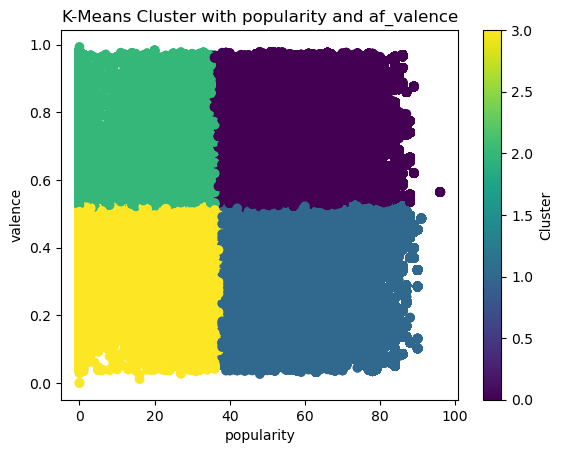

In [88]:
#plot popularity and valence cluster analysis
plt.scatter(dfC_viz["popularity"], dfC_viz["af_valence"], c=dfC_viz["cluster"])
plt.xlabel("popularity")
plt.ylabel("valence")
plt.title("K-Means Cluster with popularity and af_valence")
plt.colorbar().set_label("Cluster")
plt.show()

### Multiple Linear Regression Models

#### Predict stream count using rank and popularity

In [15]:
#create dataframe for multiple linear regression analysis
mult1 = df3_normalized.select("rank", "popularity", "streams")

In [96]:
#create features field using vector assembler
assemblerM1 = VectorAssembler(inputCols=["rank", "popularity"], outputCol="features")
dataM1 = assemblerM1.transform(mult1)
final_dataM1 = dataM1.select("features", "streams") 

In [97]:
#create training and tests data splits
train_dataM1, test_dataM1 = final_dataM1.randomSplit([0.75, 0.25], seed=42)

In [98]:
#create, fit, and train linear regression model
lrM1 = LinearRegression(featuresCol="features", labelCol="streams", predictionCol="predicted_streams")
lr_modelM1 = lrM1.fit(train_dataM1)
predictionsM1 = lr_modelM1.transform(test_dataM1)

In [103]:
#evaluate model performance
evaluatorM1 = RegressionEvaluator(labelCol="streams", predictionCol="predicted_streams", metricName="rmse")
rmseM1 = evaluatorM1.evaluate(predictionsM1)
print("Root Mean Squared Error (RMSE) on test data: {:.3f}".format(rmseM1))

evaluator_r2M1 = RegressionEvaluator(labelCol="streams", predictionCol="predicted_streams", metricName="r2")
r2M1 = evaluator_r2M1.evaluate(predictionsM1)
print("R-squared (R2) on test data: {:.3f}".format(r2M1))

Root Mean Squared Error (RMSE) on test data: 206507.528
R-squared (R2) on test data: 0.019


**Interestingly, while we may assume that stream count in our data can be predicted using rank and popularity, our linear regression model returns a large RMSE and very poor R2 score, indicating a model that does not fit to the data well. Reviewing a few samples by hand, it appears that often times stream count does seem to be severely disjointed from rank and popularity. This would be an area to explore in more detail in the future.**

#### Predict rank using popularity and stream count

In [16]:
#create features field using vector assembler
assemblerM2 = VectorAssembler(inputCols=["popularity", "streams"], outputCol="features")
dataM2 = assemblerM2.transform(mult1)
final_dataM2 = dataM2.select("features", "rank")

In [17]:
#create training and tests data splits
train_dataM2, test_dataM2 = final_dataM2.randomSplit([0.75, 0.25], seed=42)

In [18]:
#create, fit, and train linear regression model
lrM2 = LinearRegression(featuresCol="features", labelCol="rank", predictionCol="predicted_rank")
lr_modelM2 = lrM2.fit(train_dataM2)
predictionsM2 = lr_modelM2.transform(test_dataM2)

In [20]:
#evaluate model performance
evaluatorM2 = RegressionEvaluator(labelCol="rank", predictionCol="predicted_rank", metricName="rmse")
rmseM2 = evaluatorM2.evaluate(predictionsM2)
print("Root Mean Squared Error (RMSE) on test data: {:.3f}".format(rmseM2))

evaluator_r2M2 = RegressionEvaluator(labelCol="rank", predictionCol="predicted_rank", metricName="r2")
r2M2 = evaluator_r2M2.evaluate(predictionsM2)
print("R-squared (R2) on test data: {:.3f}".format(r2M2))

Root Mean Squared Error (RMSE) on test data: 57.031
R-squared (R2) on test data: 0.017


**While our RMSE dropped significantly when predicting rank using popularity and stream count, we still return a very poor R2 model. This indicates that perhaps our choice of features is not best for building a well-fitting linear regression model**

#### Predict popularity using several features

In our next linear regression experiment, we will try to predict popularity. However we will add several more features to see if this can improve the R2 score of our model.

In [28]:
#create dataframe for multiple linear regression analysis
mult3 = df3_normalized.select("streams", "duration_ms", "af_danceability", "af_energy", "popularity")

In [29]:
#create features field using vector assembler
assemblerM3 = VectorAssembler(inputCols=["streams", "duration_ms", "af_danceability", "af_energy"], outputCol="features")
dataM3 = assemblerM3.transform(mult3)
final_dataM3 = dataM3.select("features", "popularity")

In [30]:
#create training and tests data splits
train_dataM3, test_dataM3 = final_dataM3.randomSplit([0.75, 0.25], seed=42)

In [31]:
#create, fit, and train linear regression model
lrM3 = LinearRegression(featuresCol="features", labelCol="popularity", predictionCol="predicted_popularity")
lr_modelM3 = lrM3.fit(train_dataM3)
predictionsM3 = lr_modelM3.transform(test_dataM3)

In [33]:
#evaluate model performance
evaluatorM3 = RegressionEvaluator(labelCol="popularity", predictionCol="predicted_popularity", metricName="rmse")
rmseM3 = evaluatorM3.evaluate(predictionsM3)
print("Root Mean Squared Error (RMSE) on test data: {:.3f}".format(rmseM3))

evaluator_r2M3 = RegressionEvaluator(labelCol="popularity", predictionCol="predicted_popularity", metricName="r2")
r2M3 = evaluator_r2M3.evaluate(predictionsM3)
print("R-squared (R2) on test data: {:.3f}".format(r2M3))

Root Mean Squared Error (RMSE) on test data: 30.404
R-squared (R2) on test data: 0.003


**Our RMSE error dropped further, however our R2 score dropped as well. It appears that while we have success with our random forest and k-means clustering experiments, our linear regression analysis has shown that further feature engineering, principal component analysis, and normalization/scaling may be needed to achieve a good linear regressor with this dataset.**